# Linear Regression on sythentic data with Flower

In [6]:
#!pip install flwr flwr-datasets[vision] flwr[simulation]

## Defining dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt

import flwr as fl
from flwr.server.strategy import FedAvg
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.simulation import run_simulation
from flwr.common import NDArrays, Scalar, Context
from flwr.client import NumPyClient, Client, ClientApp


from collections import OrderedDict
from typing import Dict, Tuple
from torch.utils.data import DataLoader, Subset

/home/gabriele/Desktop/Thesis/ZKP-in-FML/venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-26 21:31:41,638	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [8]:
# Synthetic dataset
class SyntheticLinearDataset(Dataset):
    def __init__(self, w, b, noise, num_samples = 1000):
        x = torch.rand(num_samples, len(w)) * 100 # val between [0, 1] are mapped between [0, 100]
        self.x = (x - x.mean())/ x.std() # normalized data
        y = torch.matmul(self.x, w.reshape(-1,1)) + b + torch.randn(num_samples, 1) * noise # y = wx + b + noise
        self.y = (y - y.mean())/ y.std() # normalized data


    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def plot(self):
        print(self.x.shape, self.y.shape)
        plt.scatter(self.x, self.y)
        plt.title('Synthetic Linear Dataset')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()


def load_data(num_samples=1000, batch_size=32):
    dataset = SyntheticLinearDataset(w=torch.Tensor([3]), b = 1, noise=0.05, num_samples = num_samples)
    dataset.plot()
    train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader


torch.Size([500, 1]) torch.Size([500, 1])


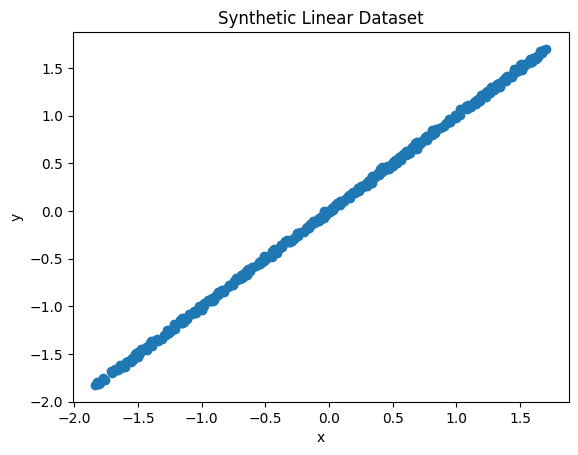

400 100


In [9]:
train_dataloader, val_dataloader = load_data(num_samples=500, batch_size=32)
print(len(train_dataloader.dataset), len(val_dataloader.dataset))

## Linear regression model

In [10]:
class LinearRegression(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [11]:
# Sample one batch
X_train, y_train = next(iter(train_dataloader))
X_val, y_val = next(iter(val_dataloader))
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])


### Centralized training

In [12]:
dataset = SyntheticLinearDataset(w=torch.Tensor([3]), b = 10, noise=0.5, num_samples = 1000)
x_train = dataset.x
y_train = dataset.y
model = LinearRegression(1,1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 4000
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())
    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [500/4000], Loss: 0.0265
Epoch [1000/4000], Loss: 0.0265
Epoch [1500/4000], Loss: 0.0265
Epoch [2000/4000], Loss: 0.0265
Epoch [2500/4000], Loss: 0.0265
Epoch [3000/4000], Loss: 0.0265
Epoch [3500/4000], Loss: 0.0265
Epoch [4000/4000], Loss: 0.0265


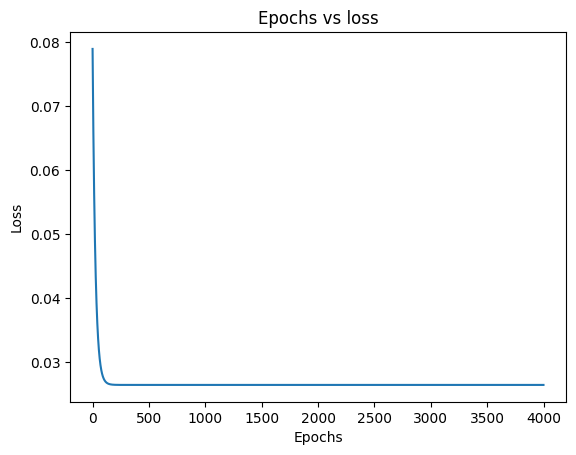

In [13]:
plt.plot(range(epochs), losses)
plt.title('Epochs vs loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

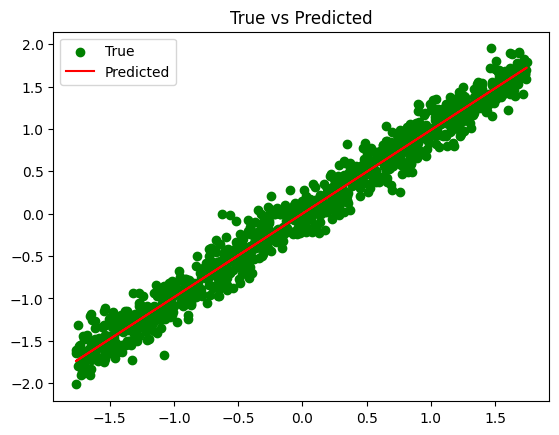

In [14]:
predicted = model(x_train).detach().numpy()
plt.scatter(x_train, y_train, label='True', color='green')
plt.plot(x_train, predicted, label='Predicted', color='red')
plt.title('True vs Predicted')
plt.legend()
plt.show()

## Federated learning with Flower

In [15]:
NUM_CLIENTS = 3
BATCH_SIZE = 32
LOCAL_EPOCHS = 1
DATASET_NUM_SAMPLES = 5000
NUM_ROUNDS = 100
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load partition for each client

Now let us define a way to laod partition for each client, using these settings they are identically and indipendently distributed.

In [16]:
def load_partitions(dataset, num_partitions, batch_size=32, partition_type="random",val_ratio: float = 0.1):

    # split the dataset training and test
    train_set, test_set = random_split(dataset, [0.8, 0.2])

    # furtherly divide trainset for each client
    partition_size = len(train_set) // num_partitions
    partition_len = [partition_size] * num_partitions

    train_sets = []

    # return a list of train_set
    if partition_type == "random":
        train_sets = random_split(train_set, partition_len, torch.Generator().manual_seed(42))
    elif partition_type == "sequence":
        sorted_train_indices = sorted(train_set.indices, key=lambda idx: train_set.dataset[idx][0])  # Based on data
        train_set = torch.utils.data.Subset(train_set.dataset, sorted_train_indices)
        for i in range(num_partitions):
            start_idx = i * partition_size
            end_idx = start_idx + partition_size
            train_sets.append(Subset(train_set, range(start_idx, end_idx)))


    trainloaders = []
    valloaders = []
    # for each train set, let's put aside some training examples for validation
    for trainset_ in train_sets:
        num_total = len(trainset_)
        num_val = int(val_ratio * num_total)
        num_train = num_total - num_val

        if partition_type == "sequence":
            for_train = Subset(trainset_, range(0, num_train))
            for_val = Subset(trainset_, range(num_train, num_total))
        else:
            for_train, for_val = random_split(
                trainset_, [num_train, num_val], torch.Generator().manual_seed(42)
            )

        # construct data loaders and append to their respective list.
        # In this way, the i-th client will get the i-th element in the trainloaders list and the i-th element in the valloaders list
        trainloaders.append(
            DataLoader(for_train, batch_size=batch_size, shuffle=True, num_workers=2)
        )
        valloaders.append(
            DataLoader(for_val, batch_size=batch_size, shuffle=False, num_workers=2)
        )


    testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloaders, valloaders, testloader

### Flower ClientApp

Standard training and test loop

In [17]:
def train(model, trainloader, epochs, device: str):
    """Train the network on the training set.

    This is a fairly simple training loop for PyTorch.
    """

    criterion = nn.MSELoss()
    optim = torch.optim.SGD(model.parameters(), lr=0.01)
    model.train()
    model.to(device)
    for _ in range(epochs):
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

In [18]:
def test(model, testloader, device: str):
    """Validate the network on the entire test set.

    and report loss and accuracy.
    """
    criterion = nn.MSELoss()
    correct, loss = 0, 0.0
    model.eval()
    model.to(device)
    with torch.no_grad():
        for data in testloader:
            x, y = data[0].to(device), data[1].to(device)
            outputs = model(x)
            loss += criterion(outputs, y).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy

In [19]:
class FlowerClient(fl.client.NumPyClient):
    """Define a Flower Client."""

    def __init__(self, trainloader, vallodaer) -> None:
        super().__init__()

        # the dataloaders that point to the data associated to this client
        self.trainloader = trainloader
        self.valloader = vallodaer

        # a model that is randomly initialised at first
        self.model = LinearRegression(1,1)

        # figure out if this client has access to GPU support or not
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def set_parameters(self, parameters):
        """Receive parameters and apply them to the local model."""
        params_dict = zip(self.model.state_dict().keys(), parameters)

        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})

        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract model parameters and return them as a list of numpy arrays."""

        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """Train model received by the server (parameters) using the data.

        that belongs to this client. Then, send it back to the server.
        """

        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)

        train(self.model, self.trainloader, LOCAL_EPOCHS, self.device)

        # return the newly updated parameters to the server
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        self.set_parameters(parameters)

        loss, accuracy = test(self.model, self.valloader, self.device)

        return float(loss), len(self.valloader), {"accuracy": accuracy}

In [20]:
# define the dataset samples
dataset = SyntheticLinearDataset(w=torch.Tensor([3]), b = 1, noise=0.05, num_samples = DATASET_NUM_SAMPLES)
train_loaders, val_loaders, test_loader = load_partitions(
    dataset,
    num_partitions=NUM_CLIENTS,
    batch_size=BATCH_SIZE,
    partition_type="sequence",
    val_ratio = 0.1
)

/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=21545) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


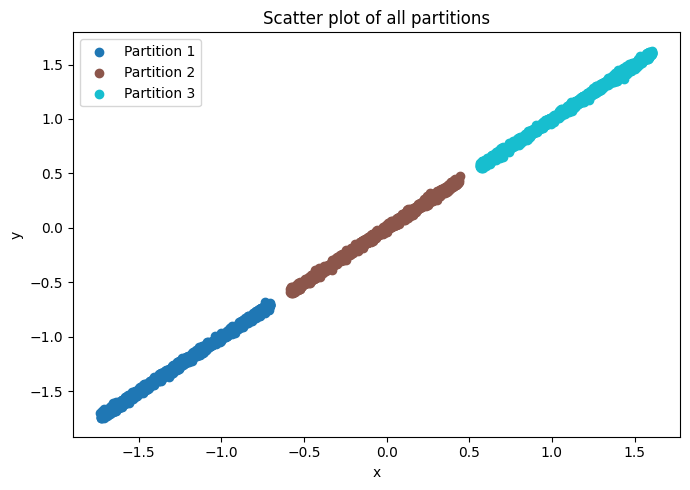

In [21]:
plt.figure(figsize=(7, 5))

# Define a list of colors, or you can use a colormap for dynamic coloring
colors = plt.get_cmap('tab10', NUM_CLIENTS)

# Loop through each partition (trainloader) and plot its data on the same figure
for i, trainloader in enumerate(train_loaders):
    # Collect all x and y values in the current partition
    x_vals = []
    y_vals = []

    for batch in trainloader:
        x_batch, y_batch = batch
        x_vals.extend(x_batch.numpy().flatten())
        y_vals.extend(y_batch.numpy().flatten())

    # Plot the partition data with a different color and label for the legend
    plt.scatter(x_vals, y_vals, color=colors(i), label=f"Partition {i+1}")

# Add title and labels for the figure
plt.title("Scatter plot of all partitions")
plt.xlabel("x")
plt.ylabel("y")

# Show the legend to differentiate partitions
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [22]:
def client_fn(context: Context) -> fl.client.Client:

    # usally a random number instantiated by the server
    node_id = context.node_id

    # number from 0 up to num clients, corresponds to dataset partitions
    partition_id = context.node_config["partition-id"]

    train_loader, test_loader = train_loaders[partition_id], val_loaders[partition_id]

    return FlowerClient(train_loader, test_loader).to_client()


# Flower ClientApp
client = ClientApp(
    client_fn=client_fn,
)

### Flower ServerApp

In [23]:
centralized_accuracy = []
centralized_loss = []

def get_evaluate_fn(
        device: str,
        testloader: DataLoader,

    ):
    """Define function for global evaluation on the server. Test loader is the full MNIST test set.
    """

    def evaluate_fn(server_round: int, parameters, config):
        # this function takes these parameters and evaluates the global model
        # on the server on a pre defined test dataset.


        # evaluate global model only at the last round
        if server_round % 2 == 0: #== total_rounds:

            model = LinearRegression(1,1)
            model.to(device)

            params_dict = zip(model.state_dict().keys(), parameters)
            state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
            model.load_state_dict(state_dict, strict=True)


            loss, accuracy = test(model, testloader, device)
            centralized_accuracy.append(accuracy)
            centralized_loss.append(loss)

            return loss, {"accuracy": accuracy}

    return evaluate_fn

In [24]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
        min_fit_clients=10,  # Never sample less than 10 clients for training
        min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
        min_available_clients=10,  # Wait until all 10 clients are available
        evaluate_fn=get_evaluate_fn(
            device=DEVICE,
            testloader=test_loader,
        ),
    )

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=NUM_ROUNDS)

    return ServerAppComponents(strategy=strategy, config=config)


In [25]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}


# Create a new server instance with the updated FedAvg strategy
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=100, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=21545) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      initial parameters (loss, other metrics): 27.742924630641937, {'accuracy': 0.0}
INFO :      
INFO :      [ROUND 1]


KeyboardInterrupt: 